#### Dependencies
____

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib inline

#### Support Functions
____ 

In [63]:
def get_train_test(dataset, model, feature, prediction_days):

    if (model == 'es'):        
        master = dataset.copy(deep=True)
        master.set_index('datetime', inplace=True)        
        master.index.freq='D'
        master = master[feature]
        master.columns = ['y']                
        
        cutoff_date = master.index.max() - pd.Timedelta(days=prediction_days)

        cond_train = master.index <= cutoff_date  
        cond_test  = master.index > cutoff_date    # max forecast time = 1 year
        
    
    elif (model == 'fp'):
        master = dataset.copy(deep=True)
        master = master[['datetime', feature]]
        master.columns = ['ds', 'y']
        
        cutoff_date = master['ds'].max() - pd.Timedelta(days=prediction_days)

        cond_train = master['ds'] <= cutoff_date  
        cond_test  = master['ds'] > cutoff_date    # max forecast time = 1 year                

    test = master[cond_test]
    train = master[cond_train]         
    
    return train, test


#### Load Data
____

In [50]:
dataset = '../resources/daily_household_power_consumption.csv'

master = pd.read_csv(dataset, infer_datetime_format=True, parse_dates=['datetime'])
master.columns

Index(['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'kitchen_active_energy', 'laundry_active_energy',
       'water_heater_ac_active_energy', 'equipment_active_energy'],
      dtype='object')

In [91]:
models = ['es', 'fp']
features = ['kitchen_active_energy', 'laundry_active_energy', 'water_heater_ac_active_energy', 'equipment_active_energy']

#### Perform model evaluation for each feature 
____

In [117]:
prediction_days = 90
results = []

for m in models:
    for f in features:        
        train, test = get_train_test(master, m, f, prediction_days)
        
        if (m == 'es'):
            model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7).fit()    
            predictions = model.forecast(steps=prediction_days)            
            rmse_score = rmse(x1 = test, x2 = predictions )
            
            results.append({
                'model'   : m,
                'feature' : f.split('_')[0],
                'rmse'    : rmse_score,
                'avg'     : test.mean(),
                'std'     : test.std()
            })
            
        elif (m == 'fp'):
            model = Prophet(seasonality_mode='multiplicative').fit(train)
            predictions = model.make_future_dataframe(periods=prediction_days, freq='D')            
            forecast = model.predict(predictions)
            
            pred_data = forecast.copy(deep=True)
            pred_data.set_index('ds', inplace=True)
            pred_data.index.freq='D'
            pred_data = pred_data.iloc[-prediction_days:]            
            
            rmse_score = rmse(x1 = test['y'], x2 = pred_data['yhat'])                   
        
            results.append({
                'model'   : m,
                'feature' : f.split('_')[0],
                'rmse'    : rmse_score,
                'avg'     : test['y'].mean(),
                'std'     : test['y'].std()
            })      


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot results
_____

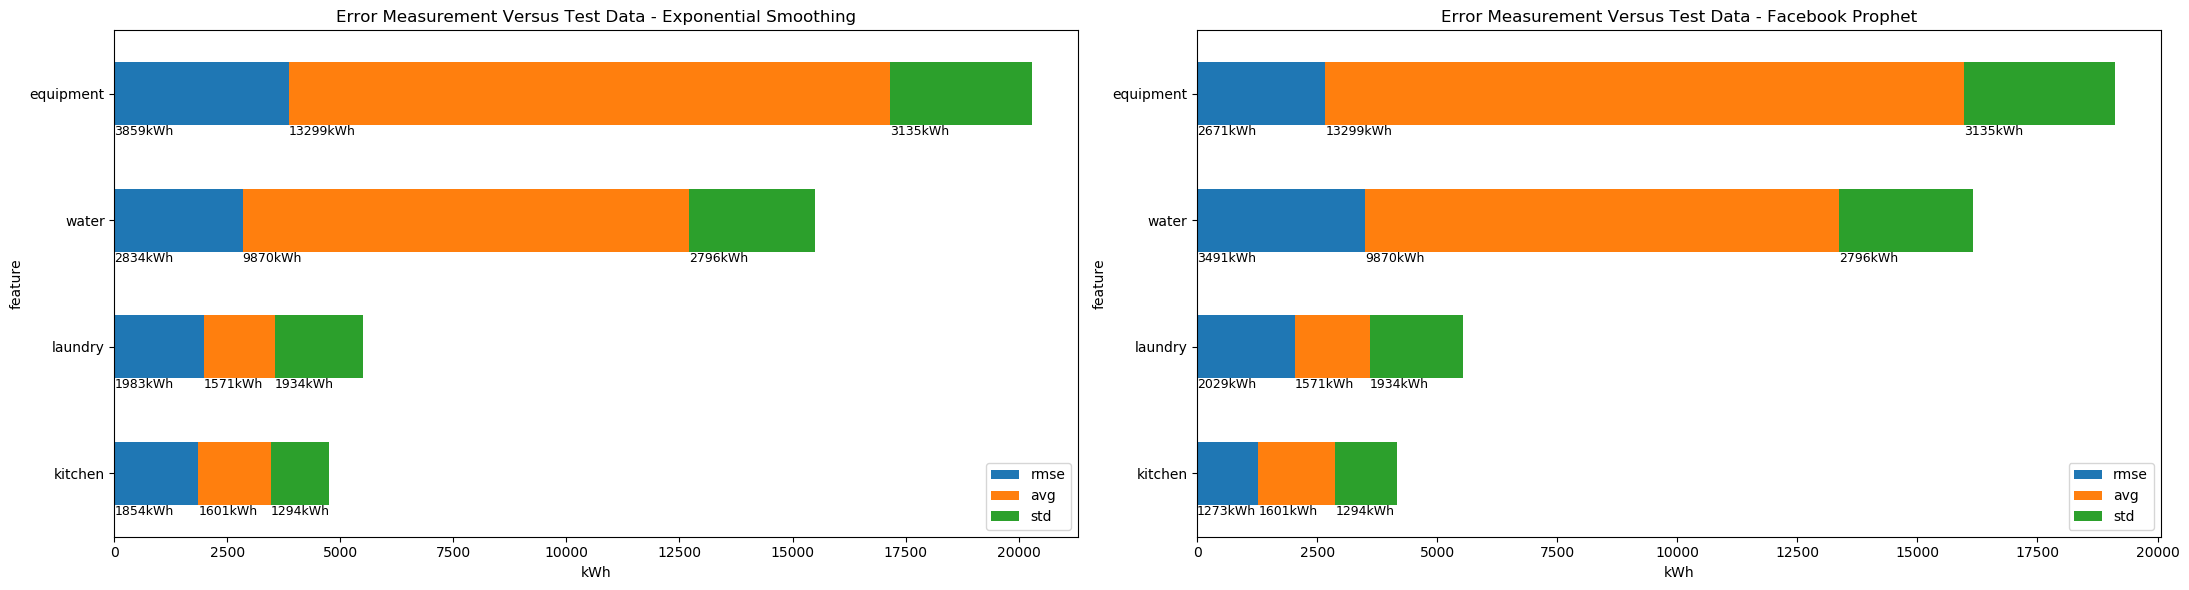

In [328]:
pred_data = pd.DataFrame(results)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 6), dpi=100)

cond1 = pred_data['model'] == 'es'
pred_data[cond1].plot(kind='barh', stacked=True, ax=ax[0], x='feature')
ax[0].set_xlabel('kWh')
ax[0].set_title('Error Measurement Versus Test Data - Exponential Smoothing')

cond2 = pred_data['model'] == 'fp'
pred_data[cond2].plot(kind='barh', stacked=True, ax=ax[1], x='feature')
ax[1].set_xlabel('kWh')
ax[1].set_title('Error Measurement Versus Test Data - Facebook Prophet')

for idx in range(len(ax)):    
    for lbl in ax[idx].patches:        
        x = lbl.get_x()
        y = lbl.get_y()
        
        ax[idx].annotate("{:.0f}kWh".format(int(lbl.get_width())),(x,y),horizontalalignment='left', verticalalignment='top', fontsize=9)
    
    
plt.tight_layout()

In [152]:
pred_data

,model,feature,rmse,avg,std
0,es,kitchen,1854.790330,1601.044444,1294.591540
1,es,laundry,1983.529439,1571.077778,1934.993402
2,es,water,2834.146686,9870.855556,2796.931768
3,es,equipment,3859.695085,13299.585555,3135.620762
4,fp,kitchen,1273.777219,1601.044444,1294.591540
5,fp,laundry,2029.255984,1571.077778,1934.993402
6,fp,water,3491.827413,9870.855556,2796.931768
7,fp,equipment,2671.030355,13299.585555,3135.620762


In [238]:
len(ax)

2